# Introduction
State notebook purpose here

### Imports
Import libraries and write settings here.

In [25]:
# Data manipulation
import pandas as pd
import numpy as np

# Options for pandas
# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 600
pd.options.display.max_rows = 100

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython import get_ipython
ipython = get_ipython()

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

# autoML
import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics
from ConfigSpace.configuration_space import Configuration
import autosklearn.classification
import PipelineProfiler


# scalers
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# models
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingClassifier
# xgboost
#from xgboost import XGBClassifier

# processing
from sklearn.preprocessing import label_binarize, PolynomialFeatures
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from mlxtend.feature_selection import ColumnSelector
from sklearn import model_selection

# feature selection
from sklearn.feature_selection import SelectFdr, f_classif, SelectKBest, SelectFromModel, VarianceThreshold, chi2

# benchmark
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, multilabel_confusion_matrix, auc, matthews_corrcoef, roc_auc_score, accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix
# Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

import pickle


# Visualizations
import matplotlib.pyplot as plt
# Set default font size
plt.rcParams['font.size'] = 24
import seaborn as sb
# Set default font size
sb.set(font_scale = .8)
custom_style = {'axes.labelcolor': 'black',
                'xtick.color': 'black',
                'ytick.color': 'black'}
sb.set_style("white", rc=custom_style)


# Interactive Visualizations
# import plotly.plotly as py
# import plotly.graph_objs as go
# from plotly.offline import iplot, init_notebook_mode
# init_notebook_mode(connected=True)

# import cufflinks as cf
# cf.go_offline(connected=True)
# icf.set_config_file(theme='white')

# Analysis/Modeling
Do work here

In [26]:
# load sample id conversion table, drug response data
drug_response_data = pd.read_csv("tables/DrugResponse_LMXfirslevel_trainTest.csv", sep="\t")
        

# load driver annotation for PDx models
f = "data/Driver_Annotation/CodingVariants_All669PDX_samples_26Feb2020_annotated_drivers_shortVersionForPDXfinder_EK.txt"
driver_data = pd.read_csv(f, "\t", header=0).rename(columns={'Sample':
'sanger_id'})

# + driver annot data
drug_mut_df = pd.merge(drug_response_data, driver_data, 
                       on="sanger_id", how="left")

# transform df to have a gene x sample binary mutation matrix
# including all driver genes
features_pre = drug_mut_df[drug_mut_df["Final_Driver_Annotation"] == True][
    ["ircc_id",
     "Gene"]
].drop_duplicates()

# 1-hot encode genes, vector sum on sample to
features_in = pd.get_dummies(features_pre.Gene)
features_in["ircc_id"] = features_pre.ircc_id
# account for multiple mut in same sample
features_in = features_in.groupby("ircc_id").sum()

features_in.shape

(230, 77)

In [27]:
target_col = "Cetuximab_Standard_3wks_cat"

Mut = features_in

f = "tables/DrugResponse_LMXfirslevel_trainTest.csv"
Y = pd.read_csv(f, sep="\t", index_col=1, header=0)
# encode target
Y_class_dict={'PD':0,'SD':1, 'OR':1}
Y[target_col] = Y[target_col].replace(Y_class_dict)

feature_col = Mut.columns

all_df = pd.merge(Mut, Y[target_col], right_index=True, left_index=True, how="right")
all_df = all_df.dropna(axis=0, how='all')
# fillna in features with median imputation
all_df[feature_col] = all_df[feature_col].\
    astype(float).apply(lambda col:col.fillna(col.median()))
# drop duplicated instances (ircc_id) from index
all_df = all_df[~all_df.index.duplicated(keep='first')]

# scale features
all_df_scaled = pd.DataFrame(MinMaxScaler().fit_transform(all_df.values),
                            columns=all_df.columns,
                            index=all_df.index)

# train-test split
train_models = Y[Y.is_test == False].index.unique()
test_models = Y[Y.is_test == True].index.unique()
X_train = all_df_scaled.loc[train_models, feature_col].values
y_train  = all_df_scaled.loc[train_models, target_col].values
X_test = all_df_scaled.loc[test_models, feature_col].values
y_test = all_df_scaled.loc[test_models, target_col].values



X_train.shape
X_test.shape

(174, 77)

(57, 77)

In [28]:
# univariate chi2 to establish a baseline for feature combos
chi2_stat, pval = [pd.Series(arr) for arr in chi2(X_train, y_train)]
chi2_df = pd.concat([chi2_stat,pval], axis=1)
chi2_df.index = feature_col
chi2_df.columns = ['chi2_stat', 'Pval']
chi2_df = chi2_df.sort_values('chi2_stat', ascending=False)
pctl_tr = chi2_df.chi2_stat.describe().loc['75%'] # set a chi2 pctl threshold
# get top gene features sorted by chi2 stat
top_features = chi2_df[(chi2_df.chi2_stat > pctl_tr)].index
chi2_df.head(30)

,chi2_stat,Pval
KRAS,17.393428,0.000030
BRAF,10.077922,0.001501
NRAS,8.483278,0.003584
PIK3CA,6.323757,0.011913
ACVR2A,4.100281,0.042876
MGA,3.779221,0.051893
FLT1,2.519481,0.112448
MLH1,2.519481,0.112448
EP300,2.519481,0.112448
ERBB2,2.519481,0.112448


In [29]:
# build new features counting the unique number of protein mut per gene per sample
pre = drug_mut_df[drug_mut_df["Final_Driver_Annotation"] == True][
    ["ircc_id",
     "Gene",
     "Protein"]
].drop_duplicates().groupby(["ircc_id", "Gene"]).Protein.nunique().\
    unstack() 

# these features are 0 when there's 0 or 1 mut in gene, else
# they hold the count of unique mut per gene
multiple_mut = pre.replace({1:np.nan}).dropna(axis=1, how='all').fillna(0)
multiple_mut.columns = [c+"_MultiMut" for c in multiple_mut.columns]

# count tot unique mut burden per sample
multiple_mut["unique_mut_burden"] = pre.apply(pd.Series.sum, axis=1)
multiple_mut.shape

(230, 19)

In [30]:
from itertools import combinations

# use only top gene features
interactions2 = list(combinations(top_features, 2))
interactions3 = list(combinations(top_features, 3))

all_df_new = all_df_scaled.copy()

new_features = []
for duo in interactions2:
    f1, f2 = duo
    v = all_df_new[f1] * all_df_new[f2]
    k = f"{f1}_{f2}_double_pos"
    all_df_new[k] = v
    new_features.append(k)

for trio in interactions3:
    f1, f2, f3 = trio
    v = (all_df_new[f1] + all_df_new[f2]  + all_df_new[f3]).replace({0 : 1, 1 : 0, 2 : 0, 3 : 0})
    k = f"{f1}_{f2}_{f3}_triple_neg"
    all_df_new[k] = v
    new_features.append(k)
    v = (all_df_new[f1] * all_df_new[f2]  * all_df_new[f3])
    k = f"{f1}_{f2}_{f3}_triple_pos"
    all_df_new[k] = v
    new_features.append(k)

# add MultiMut features
new_features.extend(multiple_mut.columns)
all_df_new = pd.merge(all_df_new, multiple_mut,
                    left_index=True,
                    right_index=True,
                    how="left")
all_df_new = all_df_new.fillna(0)
# standardise features
all_df_new_scaled = pd.DataFrame(MinMaxScaler().fit_transform(all_df_new.values),
                            columns=all_df_new.columns,
                            index=all_df_new.index)

X_train_new = all_df_new.loc[train_models, feature_col.tolist() + new_features]
X_test_new = all_df_new.loc[test_models, feature_col.tolist() + new_features]

chi2_stat, pval = [pd.Series(arr) for arr in chi2(X_train_new.values, y_train)]
chi2_df = pd.concat([chi2_stat,pval], axis=1)
chi2_df.index = X_train_new.columns
chi2_df.columns = ['chi2_stat', 'Pval']
chi2_df = chi2_df.sort_values('chi2_stat', ascending=False)
chi2_df.head(30)

,chi2_stat,Pval
KRAS_BRAF_NRAS_triple_neg,19.521565,0.000010
KRAS,17.393428,0.000030
unique_mut_burden,15.695613,0.000074
KRAS_NRAS_PTEN_triple_neg,14.784232,0.000121
KRAS_NRAS_SETD2_triple_neg,13.549430,0.000232
KRAS_NRAS_PCBP1_triple_neg,13.549430,0.000232
KRAS_NRAS_ERBB2_triple_neg,13.549430,0.000232
KRAS_NRAS_MGA_triple_neg,13.549430,0.000232
KRAS_BRAF_SETD2_triple_neg,13.549430,0.000232
KRAS_BRAF_MGA_triple_neg,13.549430,0.000232


In [31]:
features_tokeep = feature_col.tolist()
chi2_new_df = chi2_df.copy()
for gene in reversed(top_features.tolist()): # inverse rank by chi2
    # pick the best (chi2) feature duo involving gene
    gene_duos = chi2_new_df[(chi2_new_df.index.str.contains(gene)) &\
        (chi2_new_df.index.str.contains('_double_'))]
    best_duo = gene_duos.index[0]
    duos_todrop = gene_duos.index[1:].tolist() # drop the others
    # pick best trio 
    gene_trios = chi2_new_df[(chi2_new_df.index.str.contains(gene)) &\
        (chi2_new_df.index.str.contains('_triple_'))]
    best_trio = gene_trios.index[0]
    trios_todrop = gene_trios.index[1:].tolist()
    # drop unselected features
    chi2_new_df = chi2_new_df.drop(duos_todrop + trios_todrop)

In [32]:
chi2_new_df

,chi2_stat,Pval
KRAS_BRAF_NRAS_triple_neg,19.521565,0.000010
KRAS,17.393428,0.000030
unique_mut_burden,15.695613,0.000074
KRAS_PIK3CA_double_pos,12.130272,0.000496
ACVR2A_MultiMut,10.077922,0.001501
BRAF,10.077922,0.001501
NRAS,8.483278,0.003584
PIK3CA,6.323757,0.011913
PTEN_MultiMut,5.038961,0.024783
RNF43_MultiMut,5.038961,0.024783


In [33]:
features_tokeep = chi2_new_df.index.tolist()
all_df_new_scaled[features_tokeep].to_csv('tables/preprocessed_features/mut_ComboMulti.tsv',
                                          sep='\t')

X_test_new = X_test_new[features_tokeep]
X_train_new = X_train_new[features_tokeep]




In [34]:
all_df_new_scaled.head()

,ACVR2A,APC,ARID1A,ARID2,ASXL1,ATM,ATR,ATRX,AXIN2,BCL9L,BCOR,BRAF,BRCA2,CARD11,CBL,CDC73,CDH1,CDK12,CDK8,CDKN2A,CLSPN,CREBBP,CTNNB1,DUSP16,EGFR,ELF3,EP300,ERBB2,ERBB3,ERBB4,FBXW7,FGFR1,FGFR2,FLT1,GATA3,GNAS,JAK2,KDM3B,KDR,KIT,KRAS,MAP2K4,MGA,MLH1,MLH3,MSH2,MSH3,MSH6,MTOR,NF1,NF2,NRAS,PCBP1,PIK3CA,PIK3R1,PMS2,POLE,PTCH1,PTEN,RB1,RET,RNF43,SETD2,SMAD2,SMAD3,SMAD4,SOX9,STAG2,TBX3,TCF7L2,TGFBR2,TP53,TP53BP1,TRRAP,VHL,WT1,ZC3H13,Cetuximab_Standard_3wks_cat,KRAS_BRAF_double_pos,KRAS_NRAS_double_pos,KRAS_PIK3CA_double_pos,KRAS_ACVR2A_double_pos,KRAS_MGA_double_pos,KRAS_FLT1_double_pos,KRAS_MLH1_double_pos,KRAS_EP300_double_pos,KRAS_ERBB2_double_pos,KRAS_PCBP1_double_pos,KRAS_SETD2_double_pos,KRAS_SMAD3_double_pos,KRAS_PTEN_double_pos,KRAS_BRCA2_double_pos,KRAS_KIT_double_pos,KRAS_TBX3_double_pos,BRAF_NRAS_double_pos,BRAF_PIK3CA_double_pos,BRAF_ACVR2A_double_pos,BRAF_MGA_double_pos,BRAF_FLT1_double_pos,BRAF_MLH1_double_pos,BRAF_EP300_double_pos,BRAF_ERBB2_double_pos,BRAF_PCBP1_double_pos,BRAF_SETD2_double_pos,BRAF_SMAD3_double_pos,BRAF_PTEN_double_pos,BRAF_BRCA2_double_pos,BRAF_KIT_double_pos,BRAF_TBX3_double_pos,NRAS_PIK3CA_double_pos,NRAS_ACVR2A_double_pos,NRAS_MGA_double_pos,NRAS_FLT1_double_pos,NRAS_MLH1_double_pos,NRAS_EP300_double_pos,NRAS_ERBB2_double_pos,NRAS_PCBP1_double_pos,NRAS_SETD2_double_pos,NRAS_SMAD3_double_pos,NRAS_PTEN_double_pos,NRAS_BRCA2_double_pos,NRAS_KIT_double_pos,NRAS_TBX3_double_pos,PIK3CA_ACVR2A_double_pos,PIK3CA_MGA_double_pos,PIK3CA_FLT1_double_pos,PIK3CA_MLH1_double_pos,PIK3CA_EP300_double_pos,PIK3CA_ERBB2_double_pos,PIK3CA_PCBP1_double_pos,PIK3CA_SETD2_double_pos,PIK3CA_SMAD3_double_pos,PIK3CA_PTEN_double_pos,PIK3CA_BRCA2_double_pos,PIK3CA_KIT_double_pos,PIK3CA_TBX3_double_pos,ACVR2A_MGA_double_pos,ACVR2A_FLT1_double_pos,ACVR2A_MLH1_double_pos,ACVR2A_EP300_double_pos,ACVR2A_ERBB2_double_pos,ACVR2A_PCBP1_double_pos,ACVR2A_SETD2_double_pos,ACVR2A_SMAD3_double_pos,ACVR2A_PTEN_double_pos,ACVR2A_BRCA2_double_pos,ACVR2A_KIT_double_pos,ACVR2A_TBX3_double_pos,MGA_FLT1_double_pos,MGA_MLH1_double_pos,MGA_EP300_double_pos,MGA_ERBB2_double_pos,MGA_PCBP1_double_pos,MGA_SETD2_double_pos,MGA_SMAD3_double_pos,MGA_PTEN_double_pos,MGA_BRCA2_double_pos,MGA_KIT_double_pos,MGA_TBX3_double_pos,FLT1_MLH1_double_pos,FLT1_EP300_double_pos,FLT1_ERBB2_double_pos,FLT1_PCBP1_double_pos,FLT1_SETD2_double_pos,FLT1_SMAD3_double_pos,FLT1_PTEN_double_pos,FLT1_BRCA2_double_pos,FLT1_KIT_double_pos,FLT1_TBX3_double_pos,MLH1_EP300_double_pos,MLH1_ERBB2_double_pos,MLH1_PCBP1_double_pos,MLH1_SETD2_double_pos,MLH1_SMAD3_double_pos,MLH1_PTEN_double_pos,MLH1_BRCA2_double_pos,MLH1_KIT_double_pos,MLH1_TBX3_double_pos,EP300_ERBB2_double_pos,EP300_PCBP1_double_pos,EP300_SETD2_double_pos,EP300_SMAD3_double_pos,EP300_PTEN_double_pos,EP300_BRCA2_double_pos,EP300_KIT_double_pos,EP300_TBX3_double_pos,ERBB2_PCBP1_double_pos,ERBB2_SETD2_double_pos,ERBB2_SMAD3_double_pos,ERBB2_PTEN_double_pos,ERBB2_BRCA2_double_pos,ERBB2_KIT_double_pos,ERBB2_TBX3_double_pos,PCBP1_SETD2_double_pos,PCBP1_SMAD3_double_pos,PCBP1_PTEN_double_pos,PCBP1_BRCA2_double_pos,PCBP1_KIT_double_pos,PCBP1_TBX3_double_pos,SETD2_SMAD3_double_pos,SETD2_PTEN_double_pos,SETD2_BRCA2_double_pos,SETD2_KIT_double_pos,SETD2_TBX3_double_pos,SMAD3_PTEN_double_pos,SMAD3_BRCA2_double_pos,SMAD3_KIT_double_pos,SMAD3_TBX3_double_pos,PTEN_BRCA2_double_pos,PTEN_KIT_double_pos,PTEN_TBX3_double_pos,BRCA2_KIT_double_pos,BRCA2_TBX3_double_pos,KIT_TBX3_double_pos,KRAS_BRAF_NRAS_triple_neg,KRAS_BRAF_NRAS_triple_pos,KRAS_BRAF_PIK3CA_triple_neg,KRAS_BRAF_PIK3CA_triple_pos,KRAS_BRAF_ACVR2A_triple_neg,KRAS_BRAF_ACVR2A_triple_pos,KRAS_BRAF_MGA_triple_neg,KRAS_BRAF_MGA_triple_pos,KRAS_BRAF_FLT1_triple_neg,KRAS_BRAF_FLT1_triple_pos,KRAS_BRAF_MLH1_triple_neg,KRAS_BRAF_MLH1_triple_pos,KRAS_BRAF_EP300_triple_neg,KRAS_BRAF_EP300_triple_pos,KRAS_BRAF_ERBB2_triple_neg,KRAS_BRAF_ERBB2_triple_pos,KRAS_BRAF_PCBP1_triple_neg,KRAS_BRAF_PCBP1_triple_pos,KRAS_BRAF_SETD2_triple_neg,KRAS_BRAF_SETD2_triple_pos,KRAS_BRAF_SMAD3_triple_neg

In [35]:
X_train_new.shape

(174, 99)

# Results
Show graphs and stats here

In [36]:
X_test_new.shape

(57, 99)

In [37]:
# test a few classifiers, pick the best one

lr = LogisticRegression().fit(X_train_new, y_train)
svm = LinearSVC().fit(X_train_new, y_train)
knc = KNeighborsClassifier().fit(X_train_new, y_train)
rfc = RandomForestClassifier().fit(X_train_new, y_train)
[(model, accuracy_score(y_test, model.predict(X_test_new))) for model in [lr, svm, knc, rfc]]

/home/umberto.perron/anaconda3/envs/PDx_py_combio02/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[(LogisticRegression(), 0.7894736842105263),
 (LinearSVC(), 0.7192982456140351),
 (KNeighborsClassifier(), 0.7368421052631579),
 (RandomForestClassifier(), 0.7719298245614035)]

In [38]:
# pipeline to train a classifier on mutation data alone
pipe_steps = [
    #("ColumnSelector", ColumnSelector(cols=Mut_indeces)),
    ("VarianceFilter", VarianceThreshold(threshold=0)), # drop features with 0 variance
    ("chi2filterFscore", SelectKBest(chi2)), # univariate filter on chi2 stat
    ('RFClassifier', RandomForestClassifier(criterion='gini', class_weight='balanced')),
]

pipeMut = Pipeline(pipe_steps)

In [39]:
max_depths = np.linspace(1, 32, 10, endpoint=True)
hyperparameter_grid = {
          #'pipeline-1__selector__estimator__C': [1, .5, .1],
          #'pipeline-1__ANOVAfilterFscore__k': [70, 100, 150],
          #'pipeline-1__': [],
          #'pipeline-2__selector__estimator__C': [.07, .05, .03],
          #'pipeline-2__ANOVAfilterFscore__k': [150, 200, 250],
          #'pipeline-2__': [],
          'chi2filterFscore__k': [55,'all'],
          'RFClassifier__max_features' : [.2,],
          'RFClassifier__min_samples_split' : [.4,],
          'RFClassifier__n_estimators' : [15],
          'RFClassifier__max_depth' : [11],
          #'pipeline-3__' : [],
          # 'pipeline-4__ANOVAfilterFscore__k': [10, 12, 15],
          #'pipeline-4__' : [],
          #'meta_classifier__C': [.1, .01],
          #'meta_classifier__penalty': ['l2', 'elasticnet'],
          }
          
# Set up the random search with 4-fold stratified cross validation
skf = StratifiedKFold(n_splits=4,shuffle=True,random_state=42)
grid = GridSearchCV(estimator=pipeMut, 
                    param_grid=hyperparameter_grid, 
                    scoring="accuracy",
                    n_jobs=-1,
                    cv=skf,
                    refit=True,
                    verbose=2)




In [40]:
# train on gene features alone
grid.fit(X_train, y_train)

cv_keys = ('mean_test_score', 'std_test_score', 'params')

for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %r"
          % (grid.cv_results_[cv_keys[0]][r],
             grid.cv_results_[cv_keys[1]][r] / 2.0,
             grid.cv_results_[cv_keys[2]][r]))

print('Best parameters: %s' % grid.best_params_)
print('Accuracy on train: %.2f' % grid.best_score_)


# assess best classifier performance on test set
grid_test_score = grid.best_estimator_.score(X_test, y_test)
y_pred = grid.best_estimator_.predict(X_test)
print(f'Accuracy on test set: {grid_test_score:.3f}')
# print classification report on test set
print(classification_report(y_test, y_pred, target_names=['PD', 'SD-OR']))


/home/umberto.perron/anaconda3/envs/PDx_py_combio02/lib/python3.8/site-packages/sklearn/ensemble/_base.py:178: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/umberto.perron/anaconda3/envs/PDx_py_combio02/lib/python3.8/site-packages/sklearn/ensemble/_base.py:178: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
[CV] END RFClassifier__max_depth=11, RFClassifier__max_features=0.2, RFClassifier__min_samples_split=0.4, RFClassifier__n_estimators=15, chi2filterFscore__k=55; total time=   0.0s[CV] END RFClassifier__max_depth=11, RFClassifier__max_features=0.2, RFClassifier__min_samples_split=0.4, RFClassifier__n_estimators=15, chi2filterFscore__k=55; total time=   0.0s/home/umberto.perron/anaconda3/envs/PDx_py_combio02/lib/python3.8/site-packages/sklearn/ensemble/_base.py:178: UserWarning: Multiprocessin

GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('VarianceFilter',
                                        VarianceThreshold(threshold=0)),
                                       ('chi2filterFscore',
                                        SelectKBest(score_func=<function chi2 at 0x7fe0d63351f0>)),
                                       ('RFClassifier',
                                        RandomForestClassifier(class_weight='balanced'))]),
             n_jobs=-1,
             param_grid={'RFClassifier__max_depth': [11],
                         'RFClassifier__max_features': [0.2],
                         'RFClassifier__min_samples_split': [0.4],
                         'RFClassifier__n_estimators': [15],
                         'chi2filterFscore__k': [55, 'all']},
             scoring='accuracy', verbose=2)

0.736 +/- 0.04 {'RFClassifier__max_depth': 11, 'RFClassifier__max_features': 0.2, 'RFClassifier__min_samples_split': 0.4, 'RFClassifier__n_estimators': 15, 'chi2filterFscore__k': 55}
0.736 +/- 0.02 {'RFClassifier__max_depth': 11, 'RFClassifier__max_features': 0.2, 'RFClassifier__min_samples_split': 0.4, 'RFClassifier__n_estimators': 15, 'chi2filterFscore__k': 'all'}
Best parameters: {'RFClassifier__max_depth': 11, 'RFClassifier__max_features': 0.2, 'RFClassifier__min_samples_split': 0.4, 'RFClassifier__n_estimators': 15, 'chi2filterFscore__k': 55}
Accuracy on train: 0.74
Accuracy on test set: 0.754
              precision    recall  f1-score   support

          PD       0.85      0.69      0.76        32
       SD-OR       0.68      0.84      0.75        25

    accuracy                           0.75        57
   macro avg       0.76      0.76      0.75        57
weighted avg       0.77      0.75      0.75        57



In [41]:
# train on gene features + engineered features
grid.fit(X_train_new, y_train)

cv_keys = ('mean_test_score', 'std_test_score', 'params')

for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %r"
          % (grid.cv_results_[cv_keys[0]][r],
             grid.cv_results_[cv_keys[1]][r] / 2.0,
             grid.cv_results_[cv_keys[2]][r]))

print('Best parameters: %s' % grid.best_params_)
print('Accuracy on train_new: %.2f' % grid.best_score_)


# assess best classifier performance on test set
grid_test_score = grid.best_estimator_.score(X_test_new, y_test)
y_pred = grid.best_estimator_.predict(X_test_new)
print(f'Accuracy on test_new: {grid_test_score:.3f}')
# print classification report on test set
print(classification_report(y_test, y_pred, target_names=['PD', 'SD-OR']))


/home/umberto.perron/anaconda3/envs/PDx_py_combio02/lib/python3.8/site-packages/sklearn/ensemble/_base.py:178: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/umberto.perron/anaconda3/envs/PDx_py_combio02/lib/python3.8/site-packages/sklearn/ensemble/_base.py:178: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
[CV] END RFClassifier__max_depth=11, RFClassifier__max_features=0.2, RFClassifier__min_samples_split=0.4, RFClassifier__n_estimators=15, chi2filterFscore__k=55; total time=   0.0s[CV] END RFClassifier__max_depth=11, RFClassifier__max_features=0.2, RFClassifier__min_samples_split=0.4, RFClassifier__n_estimators=15, chi2filterFscore__k=55; total time=   0.0s/home/umberto.perron/anaconda3/envs/PDx_py_combio02/lib/python3.8/site-packages/sklearn/ensemble/_base.py:178: UserWarning: Multiprocessin

GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('VarianceFilter',
                                        VarianceThreshold(threshold=0)),
                                       ('chi2filterFscore',
                                        SelectKBest(score_func=<function chi2 at 0x7fe0d63351f0>)),
                                       ('RFClassifier',
                                        RandomForestClassifier(class_weight='balanced'))]),
             n_jobs=-1,
             param_grid={'RFClassifier__max_depth': [11],
                         'RFClassifier__max_features': [0.2],
                         'RFClassifier__min_samples_split': [0.4],
                         'RFClassifier__n_estimators': [15],
                         'chi2filterFscore__k': [55, 'all']},
             scoring='accuracy', verbose=2)

0.736 +/- 0.04 {'RFClassifier__max_depth': 11, 'RFClassifier__max_features': 0.2, 'RFClassifier__min_samples_split': 0.4, 'RFClassifier__n_estimators': 15, 'chi2filterFscore__k': 55}
0.770 +/- 0.01 {'RFClassifier__max_depth': 11, 'RFClassifier__max_features': 0.2, 'RFClassifier__min_samples_split': 0.4, 'RFClassifier__n_estimators': 15, 'chi2filterFscore__k': 'all'}
Best parameters: {'RFClassifier__max_depth': 11, 'RFClassifier__max_features': 0.2, 'RFClassifier__min_samples_split': 0.4, 'RFClassifier__n_estimators': 15, 'chi2filterFscore__k': 'all'}
Accuracy on train_new: 0.77
Accuracy on test_new: 0.772
              precision    recall  f1-score   support

          PD       0.95      0.62      0.75        32
       SD-OR       0.67      0.96      0.79        25

    accuracy                           0.77        57
   macro avg       0.81      0.79      0.77        57
weighted avg       0.83      0.77      0.77        57



In [42]:
y_test_predict_proba = grid.predict_proba(X_test_new)
roc_auc_score(y_test, y_test_predict_proba[:, 1])

0.818125

(0.0, 1.0)

(0.0, 1.05)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'ROC Curve')

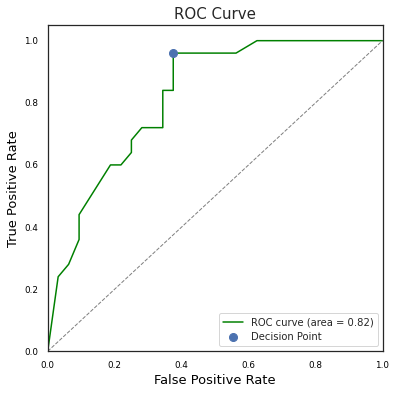

In [43]:
# plot ROC
fp_rates, tp_rates, _ = roc_curve(y_test,y_test_predict_proba[:,1])
roc_auc = auc(fp_rates, tp_rates)
fig, ax = plt.subplots(figsize=(6,6))
plt.plot(fp_rates, tp_rates, color='green',
            lw=1.5, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=1, linestyle='--', color='grey')

#plot decision point:
cm =  confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = [i for i in cm.ravel()]
plt.plot(fp/(fp+tn), tp/(tp+fn), 'bo', markersize=8, label='Decision Point')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', size=13)
plt.ylabel('True Positive Rate', size=13)
plt.title('ROC Curve', size=15)
plt.legend(loc="lower right", prop={'size': 10})
plt.subplots_adjust(wspace=.3)

In [44]:
var_selected = grid.best_estimator_[0].get_support()
chi2_selected = grid.best_estimator_[1].get_support()
selected_features = X_train_new.columns[var_selected][chi2_selected]

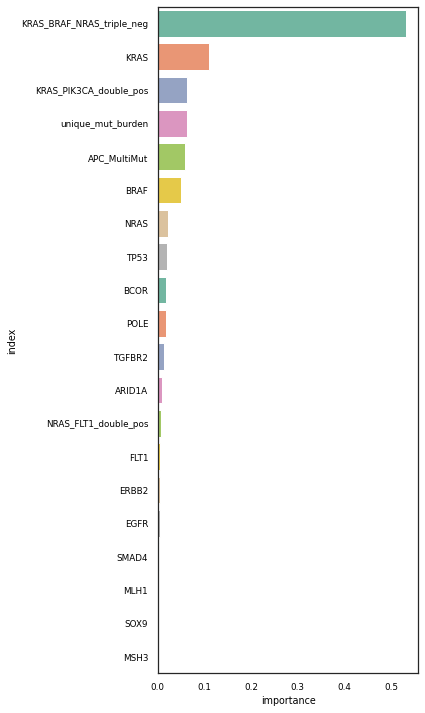

In [45]:
importance = pd.Series(grid.best_estimator_[-1].feature_importances_,
                        name='importance',
                        index=selected_features).\
                            reset_index().sort_values('importance', ascending=False)
fig,ax = plt.subplots(figsize=(6,10))
ax = sb.barplot(x="importance",
                    y="index", 
                    palette="Set2",
                    data=importance.head(20),
                    ax=ax)
plt.tight_layout()
fig.savefig('figures/OMICS_binary_mutEng_RFC_featureImportance.pdf', 
            format='pdf')

In [68]:
import graphviz
from sklearn.tree import export_graphviz
from sklearn.tree import plot_tree

ix=0
for single_tree in grid.best_estimator_[-1].estimators_:
    dot_data = export_graphviz(single_tree, 
                            feature_names=selected_features,
                            class_names=['PD', 'OR-SD'], 
                            filled=True, impurity=True, 
                            rounded=True)

    graph = graphviz.Source(dot_data, format='png')
    graph.render(f'figures/mut_featureEngineering_RFC_estimatorGraph_{ix}',format='pdf')
    ix+=1

'figures/mut_featureEngineering_RFC_estimatorGraph_0.pdf'

'figures/mut_featureEngineering_RFC_estimatorGraph_1.pdf'

'figures/mut_featureEngineering_RFC_estimatorGraph_2.pdf'

'figures/mut_featureEngineering_RFC_estimatorGraph_3.pdf'

'figures/mut_featureEngineering_RFC_estimatorGraph_4.pdf'

'figures/mut_featureEngineering_RFC_estimatorGraph_5.pdf'

'figures/mut_featureEngineering_RFC_estimatorGraph_6.pdf'

'figures/mut_featureEngineering_RFC_estimatorGraph_7.pdf'

'figures/mut_featureEngineering_RFC_estimatorGraph_8.pdf'

'figures/mut_featureEngineering_RFC_estimatorGraph_9.pdf'

'figures/mut_featureEngineering_RFC_estimatorGraph_10.pdf'

'figures/mut_featureEngineering_RFC_estimatorGraph_11.pdf'

'figures/mut_featureEngineering_RFC_estimatorGraph_12.pdf'

'figures/mut_featureEngineering_RFC_estimatorGraph_13.pdf'

'figures/mut_featureEngineering_RFC_estimatorGraph_14.pdf'

In [47]:
# vanilla auto-sklearn with no preproc, no ensemble, no metalearning
#autocls = autosklearn.classification.AutoSklearnClassifier(
#    include_preprocessors=["no_preprocessing",],
#    n_jobs=-1,
#    ensemble_size=1,
#    initial_configurations_via_metalearning=0)
#autocls.fit(X_train_new, y_train)

#autocls.cv_results_

# assess best classifier performance on test set
#y_pred = autocls.predict(X_test_new)
# print classification report on test set
#print(classification_report(y_test, y_pred, target_names=['PD', 'SD-OR']))

In [48]:
#for i, (weight, pipeline) in enumerate(autocls.get_models_with_weights()):
#    for stage_name, component in pipeline.named_steps.items():
#        print(i, component)

In [49]:
#profiler_data = PipelineProfiler.import_autosklearn(autocls)
#PipelineProfiler.plot_pipeline_matrix(profiler_data)

# Conclusions and Next Steps
Summarize findings here